### This is just simple reproducement of the code available at 

http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import tensorflow as tf

In [16]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

m = 50
n_x = X_train.shape[1]
n_y = y_train.shape[1]
n_z = 2
n_epoch = 20

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### Notation

$x$ - image,

$y$ - label,

$z$ - hidden variable

In [17]:
X = Input(shape=[n_x])
cond = Input(shape=[n_y])
inputs = concatenate([X, cond])

#### Encoder network

$ q(z|x,y) \sim \mathcal{N}(\mu_1(x, \theta), \sigma_1(x, \theta)) $

In [18]:
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model([X, cond], mu)

In [19]:
encoder.predict([X_train[0:10], y_train[0:10]])

array([[-0.56614298,  0.30428547, -0.43186334,  0.45258918, -0.09483073,
        -0.36229151,  0.07662731,  0.09490936],
       [-0.2366021 ,  0.74731559,  0.01802142,  0.54994434,  0.19551612,
        -0.47259003,  0.46612951, -0.14748636],
       [-0.15152891,  0.52409631, -0.00965083, -0.16505212,  0.09835618,
        -0.07829735,  0.2530863 ,  0.42494309],
       [-0.00516238,  0.12490141, -0.18931341,  0.23323773, -0.53335065,
         0.14951749,  0.00685311, -0.02836356],
       [ 0.38020664,  0.08589519, -0.21407896,  0.16868465, -0.20545231,
        -0.37060794,  0.01334147, -0.00474965],
       [-0.4301697 ,  0.3997016 ,  0.10413002, -0.08826777,  0.04851338,
        -0.43598017,  0.4325676 ,  0.26616755],
       [ 0.21541229,  0.18403335, -0.16531414,  0.14490776, -0.2640228 ,
        -0.43904254,  0.11984789, -0.00881718],
       [-0.47904319,  0.62099302,  0.48432517,  0.49667138, -0.47591457,
         0.05790415, -0.16085877,  0.48594004],
       [-0.15370464,  0.22008272

In [20]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=[n_z], mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X,y)
z = Lambda(sample_z)([mu, log_sigma])
z_cond = concatenate([z, cond], axis=1) # <--- NEW!

#### Decoder network

$ p(x|z,y) $

In [21]:
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z_cond)
outputs = decoder_out(h_p)

decoder_input = Input(shape=[n_z+n_y])
decoder_hidden = decoder_hidden(decoder_input)
decoder_out = decoder_out(decoder_hidden)
decoder = Model(decoder_input, decoder_out)

In [22]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs=[X, cond], outputs=outputs)

In [23]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

In [24]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit([X_train, y_train], [X_train], batch_size=50, nb_epoch=n_epoch, validation_split=0.1)

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 49500 samples, validate on 5500 samples
Epoch 1/20
49500/49500 [==============================] - 13s - loss: 498.0957 - val_loss: 434.3318
Epoch 2/20
49500/49500 [==============================] - 13s - loss: 434.9129 - val_loss: 430.5347
Epoch 3/20
49500/49500 [==============================] - 12s - loss: 431.7471 - val_loss: 430.3532
Epoch 4/20
49500/49500 [==============================] - 12s - loss: 431.6740 - val_loss: 430.3083
Epoch 5/20
49500/49500 [==============================] - 12s - loss: 431.6485 - val_loss: 430.2951
Epoch 6/20
49500/49500 [==============================] - 12s - loss: 431.6388 - val_loss: 430.2880
Epoch 7/20
49500/49500 [==============================] - 12s - loss: 431.6336 - val_loss: 430.2838
Epoch 8/20
49500/49500 [==============================] - 12s - loss: 431.6303 - val_loss: 430.2813
Epoch 9/20
49500/49500 [==============================] - 12s - loss: 431.6282 - val_loss: 430.2799
Epoch 10/20
49500/49500 [==========================

#### Now let's generate some digits

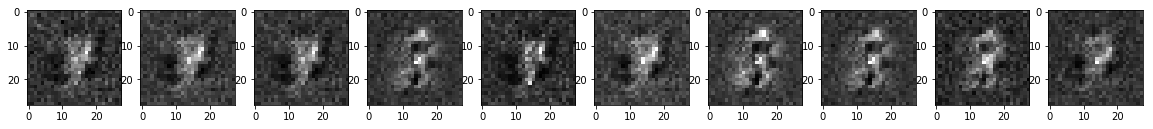

In [15]:
digit_to_generate = 8
n_samples = 10
Y = np.zeros([n_samples, 10])
Y[:, digit_to_generate] = 1
z = np.random.normal(0,1, [n_samples,2])
decoder_input = np.concatenate([z, Y],axis=1)

imgs = decoder.predict(decoder_input)

fig, axs = plt.subplots(1, 10, figsize=(20, 10))
for i in range(0, n_samples):
    axs[i].imshow(imgs[i].reshape(28,28), cmap='gray')